# Lab 13: Introduction to Time Series

### Learning goals
- Understanding how to run and interpret models with lagged variables
- Understanding what serial correlation is and why it is important
- Understanding the concept of Stationarity and how to check for it

### Literature
- [Forecasting: Principles and Practice (FPP3) Ch. 9](https://otexts.com/fpp3/arima.html)
- some of the materials in this lab are partially based on Wooldridge's *Intro to Econometrics*, but the material will be largely self-contained within the lab. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as spt

import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns




In [2]:
from cycler import cycler

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams["axes.labelsize"]= 12
plt.rcParams["figure.facecolor"] = "#f2f2f2"
#plt.rcParams['figure.savefig.dpi'] = 100
plt.rcParams['savefig.edgecolor'] = "#f2f2f2"
plt.rcParams['savefig.facecolor'] ="#f2f2f2"
plt.rcParams["figure.figsize"] = [16,10]
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['font.size'] = 14
greens = ['#66c2a4','#41ae76','#238b45','#006d2c','#00441b']
multi =['#66c2a4','#1f78b4','#a6cee3','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']
plt.rcParams["axes.prop_cycle"] = cycler(color=multi)





### Distributed lag models

Let's start with a simple and intuitive time series model called a distributed lag model. This is where we have a y-variable (or endogenous variable) which we model on an x-variable and its lags. We can write it as: 

$y_t = \alpha + \delta_0 x_t + \delta_1 x_{t-1} + \delta_2 x_{t-2} + u$

Lets say we want to analyse a temporary "shock" to this system - for example how a temporary jump in the oil price might effect industry profits over time. 

Let's say that the shock happens at time *t*. We assume that in the periods before t, the x-variable (here oil price) is constant ($x=c$).

So in the period before the shock happens we have: 

$y_{t-1} = \alpha_0 + \delta_0 c + \delta_1 c + \delta_2 c$

Then, in period t we have: 

$y_t = \alpha_0 + \delta_0 (c+1) + \delta_1 c + \delta_2 c$

And so on: 

$y_{t+1} = \alpha_0 + \delta_0 c + \delta_1 (c+1) + \delta_2 c$

$y_{t+2} = \alpha_{0} + \delta_{0} c + \delta_{1} c + \delta_{2} (c+1)$

$y_{t+3} = \alpha_0 + \delta_0 c + \delta_1 c + \delta_2 c$ 

We can look at the effect of the shock over time, which is called the impact propensity: 

| time | impact propensity |
| ------:| -----------:|
| t     | $y_t-y_{t-1} = \delta_0$ |
| t+1   | $y_{t+1}-y_{t-1} = \delta_1$ |
| t+2   | $y_{t+2} - y_{t-1} = \delta_2$ |
| t+3   | $y_{t+3} - y_{t-1} = 0$ |

Now let us say that we want to analyse a permanent effect. For example the effect of a constant CO2 tax on the electricity price. 

Again in period t we have: 

$y_t = \alpha_0 + \delta_0 (c+1) + \delta_1 c + \delta_2 c$

and then in following years: 

$y_{t+1} = \alpha_0 + \delta_0 (c+1) + \delta_1 (c+1) + \delta_2 c$

$y_{t+2} = \alpha_0 + \delta_0 (c+1) + \delta_1 (c+1) + \delta_2 (c+1)$

$y_{t+3} = \alpha_0 + \delta_0 (c+1) + \delta_1 (c+1) + \delta_2 (c+1)$ 

This is what we call "long-run propensity", or the permanent effect: 

| time  | long-run propensity| 
|:------| -----------:|
| t     | $y_t-y_{t-1} = \delta_0$ |
| t+1   | $y_{t+1}-y_{t-1} = \delta_0 + \delta_1$| 
| t+2   | $y_{t+2} - y_{t-1} = \delta_0 + \delta_1 + \delta_2$| 
| t+3   | $y_{t+3} - y_{t-1} = \delta_0 + \delta_1 + \delta_2$| 

### Serial correlation

If we want correct standard errors, and in turn inference in our time-series, then we have to take account of possible serial correlation (or autocorrelation) in our error term. You can read more generally about serial correlation [here](https://otexts.com/fpp3/acf.html)

We define serial correlation as: 

$corr(u_t, u_s | X)$

where $t\neq s$ 

That is to say that there is correlation over time between the different error terms. Intuitively, if we look at the residuals of a regresion, then without serial correlation they should look random--centered around 0, sometimes a bit positive, sometimes a bit negative, but with no recognizeable pattern. 

#### Log transformation

As we have discussed earlier, we often want to [log-transform](https://otexts.com/fpp3/nonlinear-regression.html) our data

* Sometimes we do a log-transform in order to make data more linear (especially data that is subject to steady growth rates over time) or more normal. 

* If you transform both sides of an equation, it can sometimes make the results easier to interpret--you can interpret the results as an elasticity. A percent change in one variable is correlated to a percent change in another variable.

Let's say we want to analyse the effects of wind power (W) on prices (P). These two series are in different units, so it may be easier to interpret them as elasticities.  We can log-transform my regresion: 

$log(P_t) = \alpha_0 + \delta_0 * log(W_t) + \delta_1*log(W_{t-1}) + \delta_2*log(W_{t-2})$

$\delta_0$ is interpreted as a short-term elasticity: $\delta_0 = \frac{\% \Delta P_t}{\% \Delta W_t}$

The long-term elasticity would be: $\delta_0 + \delta_1 + \delta_2$

* Remember: to log-transform a variable, all values in a series MUST be positive and non-zero. 

#### Dummy variables in time series regresion

We can include dummy-variables in our time series regresion. For example, let us say that we want to estimate the effect of a new environmental rule on oil production. Perhaps then we do the following regresion: 

$log(Q_t) = \beta X_t + \delta D_t + u_t$

Where $D_t = [0,0,0,0,1,1,1,1,1,1,1]$, where the 1's signify the periods after the new rule was put in place. 

#### Trends

Often, we want to model a trend in our data. 

We can write a linear trend as: 

$y_t = \alpha + \beta*t + u_t$

We can simulate this in python: 

In [15]:
T= 100
u_t = np.random.normal(0,1,T)
t = np.arange(0,T,1)
alpha = 2.5
beta =.3
y_t = alpha + beta*t + u_t

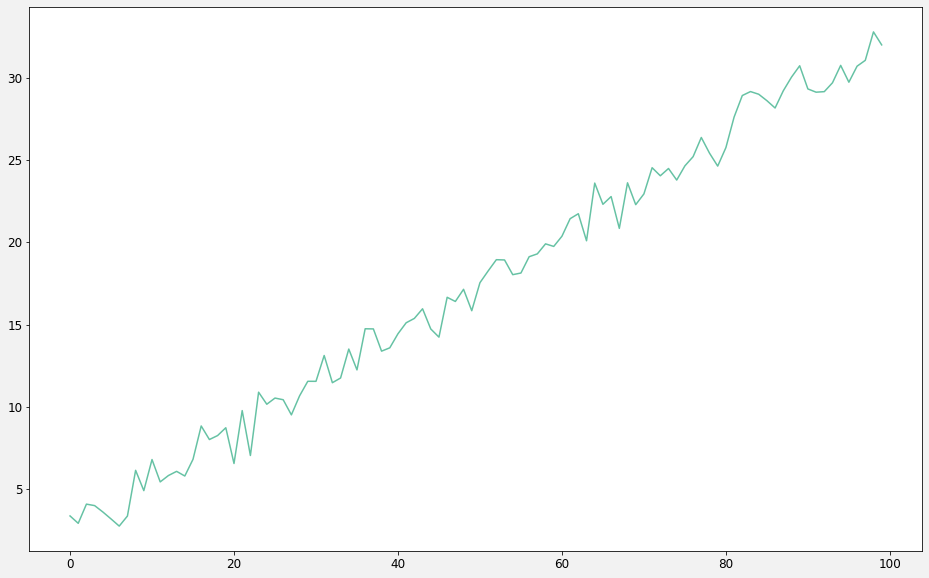

In [16]:
fig, ax = plt.subplots()
ax.plot(t, y_t)

If we model $log(y_t)$, then we would get an exponential trend (which corresponds to a constant rate of growth over time, rather than a constant absolute increase over time.)

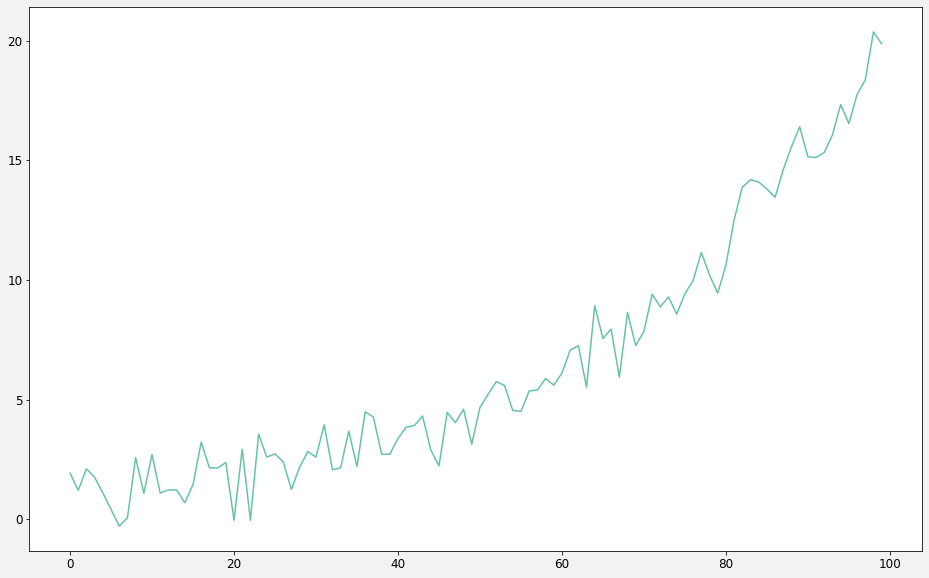

In [19]:
beta = .03 #Now an exponential coefficient - growth rate of 3% per year

y_exp = np.exp(alpha + beta*t) + u_t

fig, ax = plt.subplots()
ax.plot(t, y_exp)

## Time series with Python and pandas

Python and Pandas are excellent to work with time series data. In fact Pandas is designed to work particularly well with time-series data, without extra packages (as is required with R's Data Frame object and base types). 

## A little bit about the Nordic electricity market

The data we will use comes from the nordic electricity market. The Nordic market is a so-called "zonal" market. That means that the market is split up into zones or areas where a uniform electricity price is established for each hour of the day.  Norway has 5 zones, Sweden 4, Denmark 2 and Finland just 1. You can see a map of the zones [here](https://www.nordpoolgroup.com/maps/#/nordic). (By the way, the other major geographical pricing system is called "Nodal" market, which allows prices to vary at a much finer level depending on the state of transmission and the marginal generation costs at a location (node), but it also becomes necessarily more complex and less transparent.

There are several distinct markets for trading electricity, but the main market run by Nord Pool is the day-ahead market (sometimes misleadingly called "Nord Pool Spot".) Up until 1200 the day before delivery, producers submit supply schedules - basically telling Nord Pool how much they are willing to produce for any given price for each hour of the following day. 

Wholesale consumers (like retailing companies and large commercial consumers) submit demand schedules - saying how much they want to buy at given prices for each hour of the day. 

These supply and demand schedules are then used to create aggregated supply and demand curves for the entire market, where a price that clears the market is established (that is, a price is established where producers sell everything they want given the price, and consumers buy everything they want given the price.)

But this "system price" assumes no congestion and transmission bottlenecks in the system, and in particular between the price areas, which there almost always are. Therefor, Nord Pool adjusts the individual zonal prices until the market clears in each price zone. Thus if there is congestion between eastern Denmark (DK2) and southern Sweden (SE4), with Denmark having too much supply at the system price and Sweden having too little, prices will rise in Sweden and fall in Denmark until supply meets demand. Notably, electricity will always have a net-flow from high price areas to low-price areas. 

We will import series that represent wind power production and a series on prices on the wholesale electricity market

In [3]:
#Wind production from Sweden and Denmark (in MWh)
wind_prod =pd.read_csv("http://jmaurit.github.io/norwayeconomy/data_series/dk_se_wind_data.csv")

#The price of power (on the day-ahead market) (EUR/MWh)
elspot = pd.read_csv("http://jmaurit.github.io/norwayeconomy/data_series/elspot.csv")

First, let's format the date variable for each data frame to be *datetime* format

In [4]:
wind_prod["date"] = pd.to_datetime(wind_prod.date, format="%Y-%m-%d")

In [5]:
elspot["date"] = pd.to_datetime(elspot.date, format="%Y-%m-%d")

Let us limit our series to data for the two Danish price areas: DK1 an DK2, and then we will merge the data set into one data frame

In [6]:
DK_df = wind_prod[["date", "DK1", "DK2"]].merge(elspot[["date", "DK1","DK2"]], on="date", how="inner")

In [7]:
DK_df.columns = ["date", "DK1_wind", "DK2_wind", "DK1_price", "DK2_price"]

In [8]:
DK_df

,date,DK1_wind,DK2_wind,DK1_price,DK2_price
0,2013-01-01,20882,11388,4077,4089.0
1,2013-02-01,9254,5969,3940,4020.0
2,2013-03-01,13550,6160,4033,4158.0
3,2013-04-01,4965,2115,4282,4355.0
4,2013-05-01,7106,991,3682,3740.0
...,...,...,...,...,...
67,2018-08-01,2489,1775,5569,5684.0
68,2018-09-01,3017,1609,4989,5179.0
69,2018-10-01,32970,6256,4748,5090.0
70,2018-11-01,31766,4920,5404,5468.0


Let's plot wind power over time: 

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

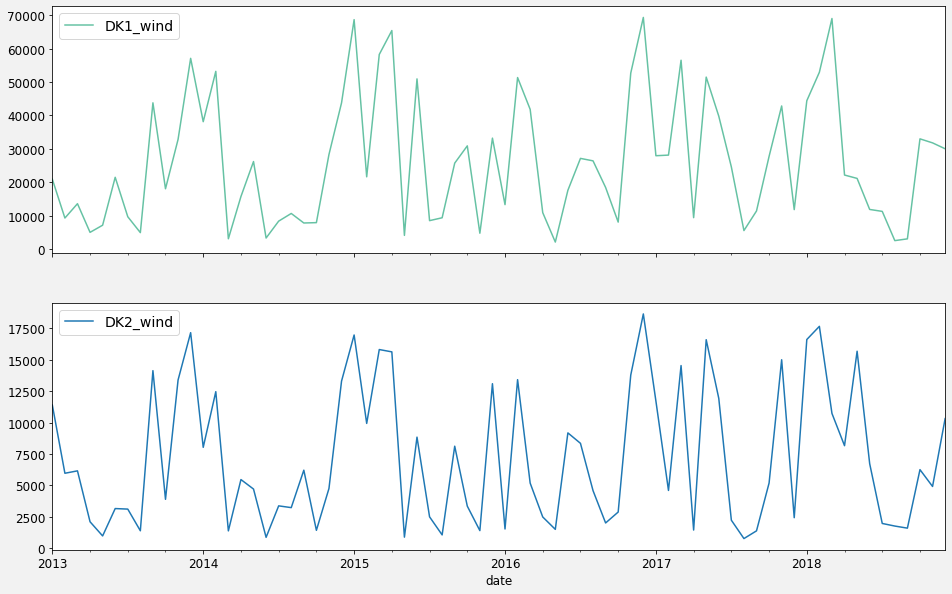

In [46]:
DK_df[["date", "DK1_wind", "DK2_wind"]].set_index("date").plot(subplots=True)

We can notice first that our frequency is monthly data. The normal frequency in the electricity data is hourly data, so here we are looking at quite aggregated data. 

We can also see that wind power is very variable, even when aggregated monthly.

Here we also see that there is much more wind power generation in the DK1 area. This is the western, peninsula part of Denmark. There is both more land mass and better wind resources in this part, so it makes sense that most of the wind power capacity is in this part. However, a larger part of consumption takes place in the DK2 area -- where copenhagen is.

Then we can look at prices:

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

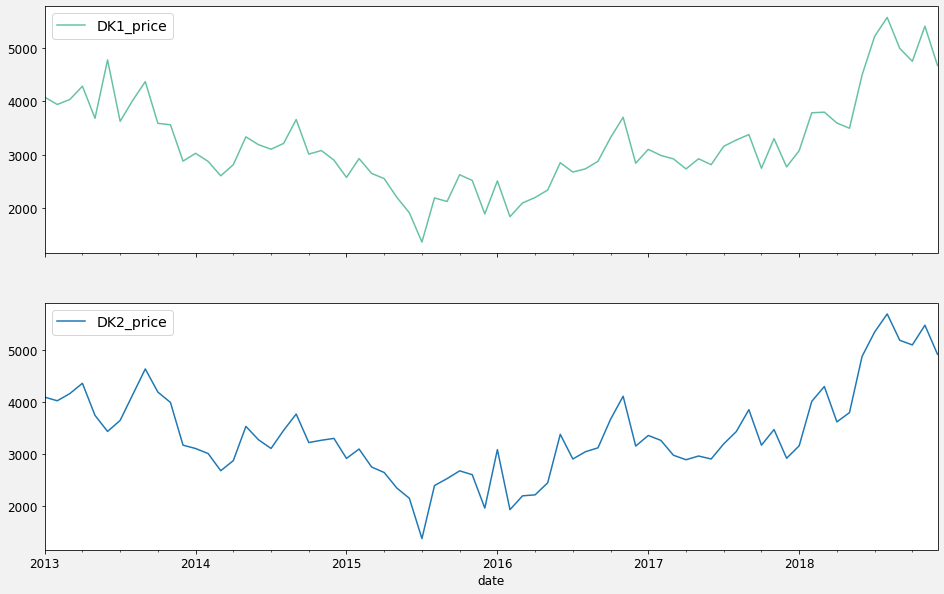

In [47]:
DK_df[["date", "DK1_price", "DK2_price"]].set_index("date").plot(subplots=True)

The main thing to notice is that prices in the two areas are quite close. DK2 prices have a tendency to be slightly higher than DK1.


Now let's run a simple linear regression where we try to explain prices in DK1 based on wind power production in the two areas and the price in DK2. 

In [49]:
static_mod0 = smf.ols(formula="DK1_price ~ DK2_price + DK1_wind + DK2_wind", data=DK_df).fit()

In [50]:
static_mod0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              DK1_price   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     306.0
Date:                Tue, 22 Feb 2022   Prob (F-statistic):           2.10e-39
Time:                        07:18:21   Log-Likelihood:                -492.67
No. Observations:                  72   AIC:                             993.3
Df Residuals:                      68   BIC:                             1002.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.0895    123.769      0.114      0.910    -232.888     261.067
DK2_price      0.9599      0.032     29.634      0.000       0.895       1.025
DK1_wind      -0.0008      0.003     -0.279      0.781      -0.006       0.005
DK2_wind      -0.0044      0.010     -0.459      0.648      -0.023       0.015
==============================================================================
Omnibus:                       91.981   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1884.145
Skew:                           3.656   Prob(JB):                         0.00
Kurtosis:                      26.970   Cond. No.                     1.51e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### What's wrong with the regression?

So here we see that DK2 price is a strong predictor of DK1 prices (which we saw from the graph above.) We get a regression with a very high R-squared (a very good fit). Wind power, as interpreted from this regression, does not appear to have a "statistically significant" affect on prices. 

But are there things that are wrong with this regression? 

Many, in fact:

1. The DK1 price series probably is not *stationary*. *Stationarity* is one of the key concepts in time series and forecasting, and we will come back to it later in this lab. You can read more [here](https://otexts.com/fpp3/stationarity.html).

2. Including prices in DK2 as a predictor probably doesn't make sense, since prices in DK1 and DK2 are co-determined at the same time in the day-ahead market. By including DK2 we are getting a very high fit, but we are not estimating a particularly useful model.

3. We have not taken into account any dynamics in the time series, like autocorrelation in the price series (more on this later). 

4. The wind power coefficients are not "statistically significant". But does that mean that we should completly discount the negative coefficients that are estimated, as the typical hypothesis testing frameworks suggest? Probably not. As we noted, this is very aggregated data, and having more data at a higher frequency may give different results

## Hourly data and stationarity. 

Lets now deal directly with two of the issues in the initial linear regression: that the data was too aggregated and the issue of stationarity. 

First, we now use hourly data on the Nordic electricity market. The data is originally from the website of [Nord Pool](https://www.nordpoolgroup.com), which I have cleaned and organized. (Nord pool has recently put their historical data behind a pay wall, but much of the same data can be found at the website for [Entso-E](https://transparency.entsoe.eu)

In [51]:
wt_data = pd.read_csv("http://jmaurit.github.io/analytics/labs/data/wt_data2.csv")

The data set includes many columns that represent prices, wind power production and transmission between areas. But we want to go back to our original question of how wind power effects prices on the market. 

But first let us pull out a few of the series we are interested in and plot them

In [56]:
DK_df2 = wt_data[["time", "hour", "wind_DK1", "wind_DK2", "DK1EurMW", "DK2EurMW"]].copy()

In [57]:
DK_df2

,time,hour,wind_DK1,wind_DK2,DK1EurMW,DK2EurMW
0,2016-01-01 00:00:00,00 - 01,1314.0,113.0,1639.0,1639.0
1,2016-01-01 01:00:00,01 - 02,1267.0,98.0,1604.0,1604.0
2,2016-01-01 02:00:00,02 - 03,1159.0,74.0,1574.0,1574.0
3,2016-01-01 03:00:00,03 - 04,1160.0,61.0,1557.0,1557.0
4,2016-01-01 04:00:00,04 - 05,1069.0,47.0,1547.0,1547.0
...,...,...,...,...,...,...
26299,2018-12-31 19:00:00,19 - 20,3335.0,800.0,4751.0,4751.0
26300,2018-12-31 20:00:00,20 - 21,3147.0,865.0,4582.0,4582.0
26301,2018-12-31 21:00:00,21 - 22,2859.0,902.0,4303.0,4303.0
26302,2018-12-31 22:00:00,22 - 23,2708.0,792.0,3854.0,3854.0


In [58]:
DK_df2["time"] = pd.to_datetime(DK_df2.time, format="%Y-%m-%d %H:%M:%S")

array([[<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
       [<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>]],
      dtype=object)

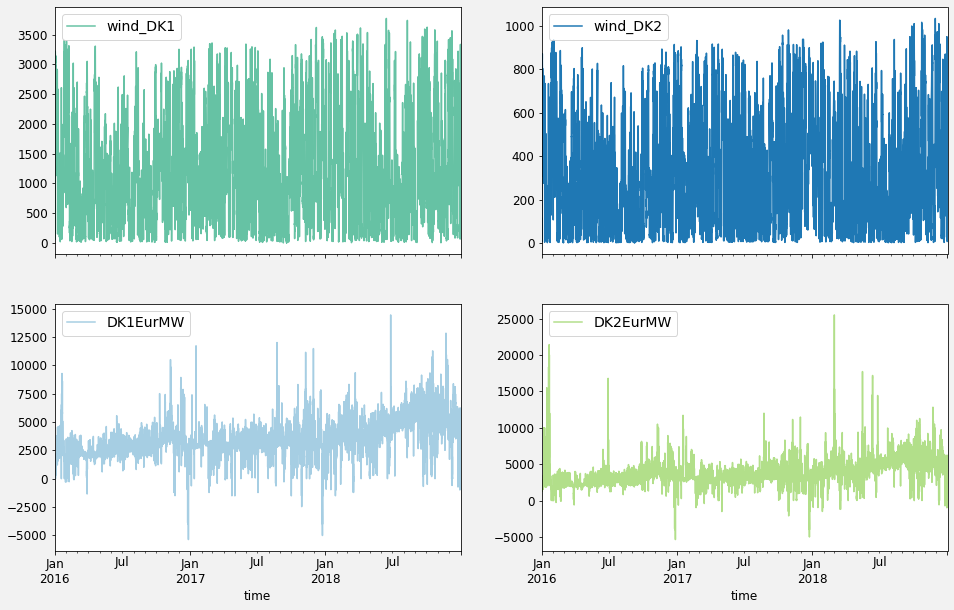

In [62]:
DK_df2[["time", "wind_DK1", "wind_DK2", "DK1EurMW", "DK2EurMW"]].set_index("time").plot(subplots=True, layout=(2,2))

<AxesSubplot:>

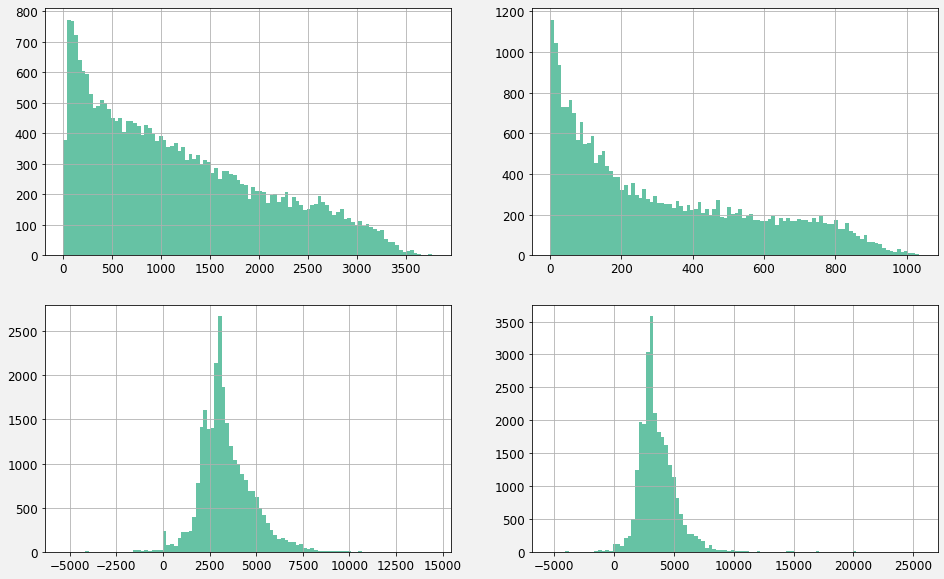

In [71]:
fig, ax = plt.subplots(2,2)
DK_df2.wind_DK1.hist(bins=100, ax=ax[0,0])
DK_df2.wind_DK2.hist(bins=100, ax=ax[0,1])
DK_df2.DK1EurMW.hist(bins=100, ax=ax[1,0])
DK_df2.DK2EurMW.hist(bins=100, ax=ax[1,1])




We can notice a few things from the line plots and histograms above. There is lots of variance in the wind power series and also in the price series. Prices are subject to occasional large spikes. In the distributions, wind power is clearly not normally distributed, while prices have a more normal shape, but seem to have a long positive tail ("positively skewed"). 

### Distributed lag model

We'll start by creating a simple model of prices in DK1 on wind power and it's lagged values, which we will estimate by OLS. 

we'll create the lagged variables first. We first make sure the data set is sorted, and then set the time-variable as the index: 

In [ ]:
DK_df2.sort_values('time', inplace=True)
DK_df2.set_index('time', inplace=True)

In [97]:
DK_df2["wind_DK1_l"] = DK_df2.wind_DK1.shift(freq="1H") #shift 1 hour
DK_df2["wind_DK1_l2"] = DK_df2.wind_DK1.shift(freq="2H") #shift 1 hour

DK_df2["wind_DK1_l3"] = DK_df2.wind_DK1.shift(freq="3H") #shift 1 hour




In [98]:
DK_df2

,hour,wind_DK1,wind_DK2,DK1EurMW,DK2EurMW,wind_DK1_l,DK1EurMW_l,wind_DK1_2l,wind_DK1_l2,wind_DK1_l3
time,,,,,,,,,,
2016-01-01 00:00:00,00 - 01,1314.0,113.0,1639.0,1639.0,NaN,NaN,NaN,NaN,NaN
2016-01-01 01:00:00,01 - 02,1267.0,98.0,1604.0,1604.0,1314.0,1639.0,NaN,NaN,NaN
2016-01-01 02:00:00,02 - 03,1159.0,74.0,1574.0,1574.0,1267.0,1604.0,1314.0,1314.0,NaN
2016-01-01 03:00:00,03 - 04,1160.0,61.0,1557.0,1557.0,1159.0,1574.0,1267.0,1267.0,1314.0
2016-01-01 04:00:00,04 - 05,1069.0,47.0,1547.0,1547.0,1160.0,1557.0,1159.0,1159.0,1267.0
...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,19 - 20,3335.0,800.0,4751.0,4751.0,3265.0,4935.0,3120.0,3120.0,3013.0
2018-12-31 20:00:00,20 - 21,3147.0,865.0,4582.0,4582.0,3335.0,4751.0,3265.0,3265.0,3120.0
2018-12-31 21:00:00,21 - 22,2859.0,902.0,4303.0,4303.0,3147.0,4582.0,3335.0,3335.0,3265.0


In [99]:
dlmod1 = smf.ols(formula="DK1EurMW~ wind_DK1 + wind_DK1_l + wind_DK1_l2 + wind_DK1_l3", data=DK_df2).fit()

In [100]:
dlmod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               DK1EurMW   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     750.9
Date:                Tue, 22 Feb 2022   Prob (F-statistic):               0.00
Time:                        14:32:34   Log-Likelihood:            -2.2670e+05
No. Observations:               26289   AIC:                         4.534e+05
Df Residuals:                   26284   BIC:                         4.534e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3973.3844     13.982    284.181      0.000    3945.979    4000.790
wind_DK1       -0.3389      0.083     -4.103      0.000      -0.501      -0.177
wind_DK1_l      0.0098      0.151      0.065      0.948      -0.286       0.306
wind_DK1_l2     0.0509      0.151      0.337      0.736      -0.245       0.347
wind_DK1_l3    -0.2415      0.083     -2.924      0.003      -0.403      -0.080
==============================================================================
Omnibus:                     2799.785   Durbin-Watson:                   0.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6120.339
Skew:                           0.664   Prob(JB):                         0.00
Kurtosis:                       4.956   Cond. No.                     4.96e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now we get a significant and negative coefficient on the wind variable as well as a third lag of the variable. From this regression we could interpret the results as evidence that wind power has a tendency to push down prices in the power market. But we still have the potential problem of stationarity. We'll spend a little time on this before we move on. 

### Stationarity and persistence

Lets first run a regression  of the price series on its own lag - a so-called autoregressive (AR) model:

In [101]:
DK_df2["DK1EurMW_l1"] = DK_df2.DK1EurMW.shift(freq="1H") #shift 1 hour

In [103]:
ARmod1 = smf.ols(formula="DK1EurMW~DK1EurMW_l1", data=DK_df2).fit()

In [104]:
ARmod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               DK1EurMW   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 2.857e+05
Date:                Tue, 22 Feb 2022   Prob (F-statistic):               0.00
Time:                        14:37:08   Log-Likelihood:            -1.9566e+05
No. Observations:               26297   AIC:                         3.913e+05
Df Residuals:                   26295   BIC:                         3.913e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     144.7351      6.530     22.164      0.000     131.936     157.534
DK1EurMW_l1     0.9569      0.002    534.544      0.000       0.953       0.960
==============================================================================
Omnibus:                     6953.139   Durbin-Watson:                   1.411
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           235038.192
Skew:                           0.608   Prob(JB):                         0.00
Kurtosis:                      17.595   Cond. No.                     9.37e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The key point from reading this regression is that the coefficient on the lagged term is very close to 1. We can interpret this to mean that a shock in a certain hour, will then carry over nearly completely to the next hour. Shocks to price, in other words, tend not to dissipate quickly. This is what it means to be highly-persistent. And highly-persistent time series tend to be non-stationary, which makes it hard to interpret a regression. 

### Random Walk

The simplest form of a persistent (and non-stationary) time series is a random walk: you can read more [here](https://otexts.com/fpp3/stationarity.html). The simple random walk model can be writen as: 

$$y_t = y_{t-1} + e_t$$

Intuitively, lets say that oil prices are a random walk. That would mean that the price today is the same as the price yesterday plus some random ("stochastic") jump (either positive or negative). In terms of forecasting, that means the best forecast of the oil price tomorrow is the oil price today!

We can simulate a random walk easily in Python: 

In [121]:
R=50
C=30
Y = np.empty(shape=[R,C])

for c in range(C):
    e = np.random.normal(0,1,R)
    y = np.cumsum(e)
    Y[:,c] = y

Y = pd.DataFrame(Y)


<AxesSubplot:>

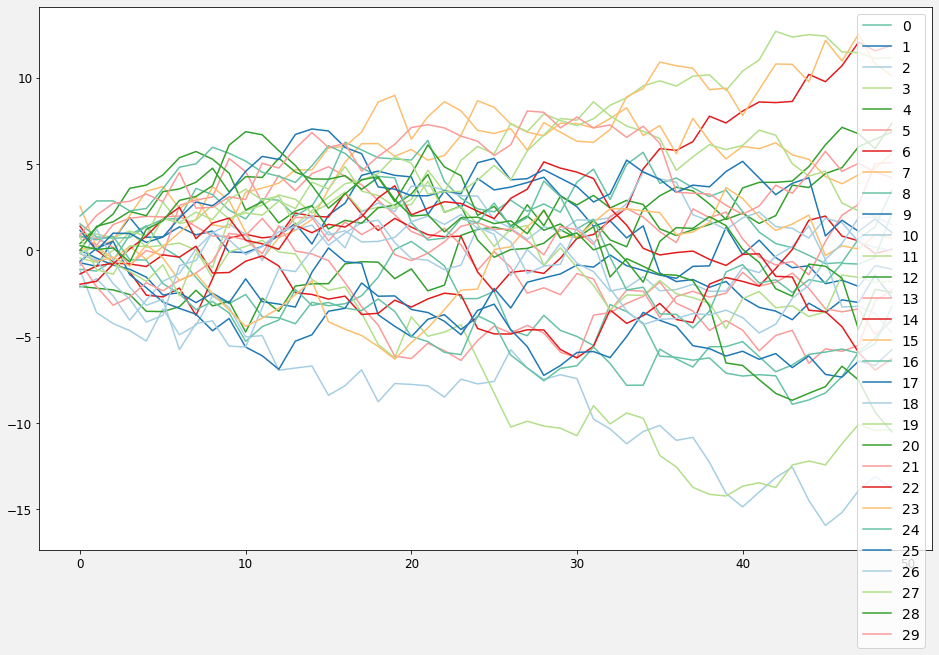

In [123]:
Y.plot()

The figure shows 30 simulated time series of 50 periods each. 

One thing we can notice is how the variance increases over time. This violates one of our criteria for using OLS - a constant variance. 

We can also notice how the series tends to move in all sorts of directions. There is no reversion to some well-defined mean, even though all the series come from exactly the same process. This is getting closer to the definition of non-stationarity, and it gives some intuition on why using a non-stationary series can give misleading results. Imagine telling a story about any one of the random draws -- one goes up, another down, another nearly straight -- but all come from exactly the same random process. All these stories and interpretations of any one of these series is essentially wrong, since really what we see are just random movements.  

## Stationarity - a bit more formally

A litte bit more formally, we define covariance stationarity as when: 

*$E(x_t)$ is stable

*$var(x_t)$ is stable

We have already seen some time series that are not stationary:

* Time series with a trend (mean is not stable)

* Very persistent time series (random walk)

Why do we care about stationarity? Because if we want to learn something about the behaviour of a time series or the interaction of two time series, then those time series should be stable over time. 

### Criteria for stationarity.

In a normal regression, we had random sampling -- that is, that the order of the data should not matter-- as a criteria for making correct inference. But in time-series we don't have random sampling. By definition, the data is ordered by time. 

So instead, as a criteria we have what we call "weak dependence".

We can write this as:

$corr(x_t, x_{t+h})\rightarrow0$ as *h* gets big. 

Basically, this says that correlations between data will go to zero as the distance between data points gets large. 

Another way of thinking about this is to say that a shock to the system will die out over time and not be permanent. 

#### AR(1) process

Lets go back to our simple AR(1) process:

$y_t = \rho y_{t-1} + e_t$

Lets set $\rho=.5$ and simulate:

<AxesSubplot:>

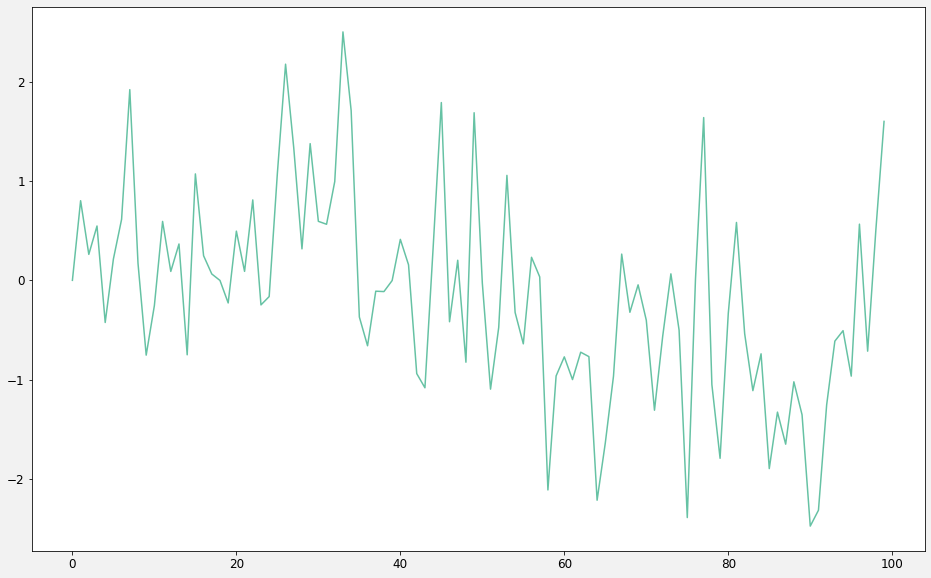

In [134]:
T=100
e = np.random.normal(0,1,T)
rho = .5 # the autoregressive coefficient
y = [0] #initial value 0
for i in range(T-1):
    y.append(rho*y[i] + e[i])
y = pd.Series(y)
y.plot()

Now lets set $\rho=1$:

<AxesSubplot:>

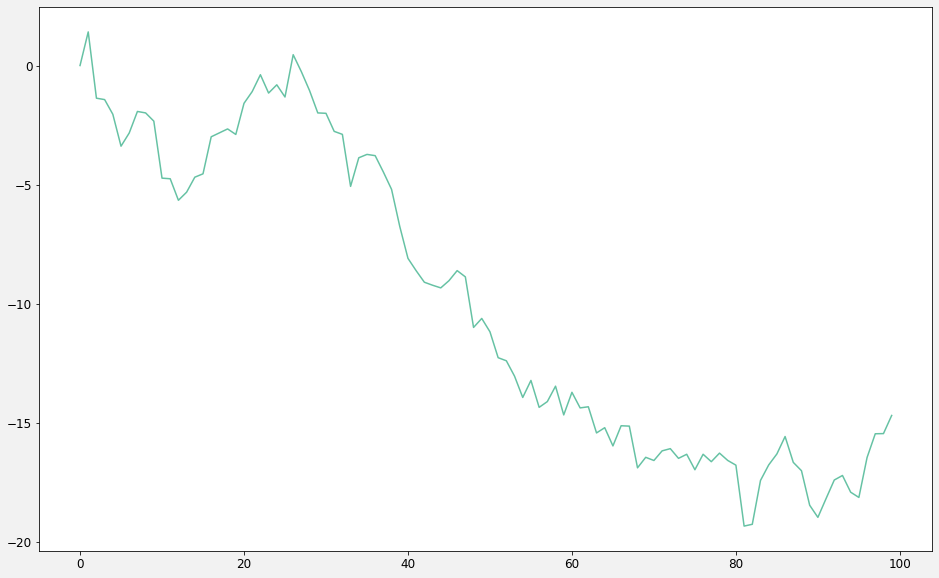

In [135]:
T=100
e = np.random.normal(0,1,T)
rho = 1 # the autoregressive coefficient
y = [0] #initial value 0
for i in range(T-1):
    y.append(rho*y[i] + e[i])
y = pd.Series(y)
y.plot()

Then we'll set $\rho=1.05$ to just over 1:


<AxesSubplot:>

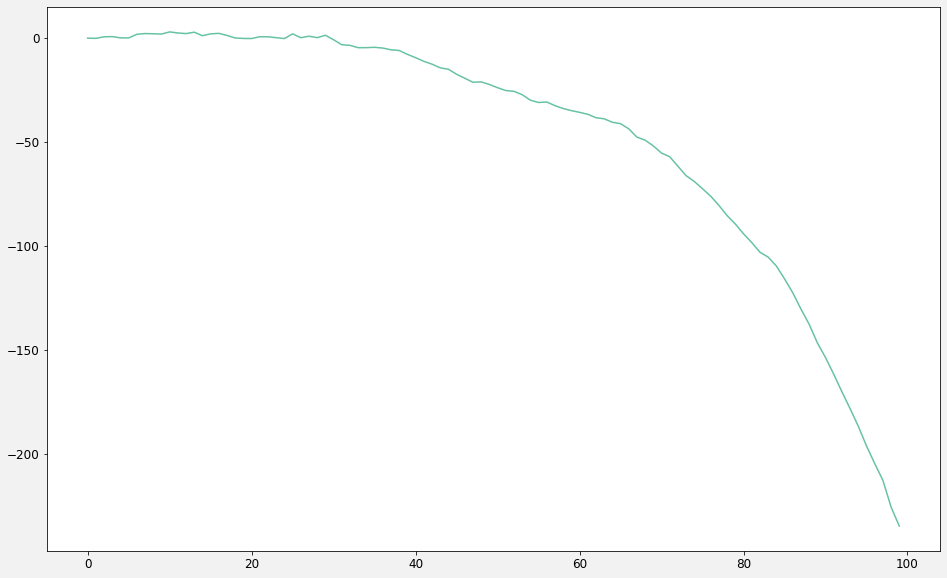

In [138]:
T=100
e = np.random.normal(0,1,T)
rho = 1.05 # the autoregressive coefficient
y = [0] #initial value 0
for i in range(T-1):
    y.append(rho*y[i] + e[i])
y = pd.Series(y)
y.plot()

Which of these three look most stable?

In general, an AR(1) series is weakly dependent and stationary when $|\rho|<1$.


### Transformation of highly persistent data 

If we have a highly persistent time series, we will often call it $I(1)$: integrated of order one, or a unit-root process.

What we want is a $I(0)$: Integrated of order 0 process, or a weakly persistent process. 

A good strategy for transforming an $I(1)$ series, is to take a difference (this will of course also change our interpretation of the results).

We start by generating a random walk series (non-stationary, I(I)). 


<AxesSubplot:>

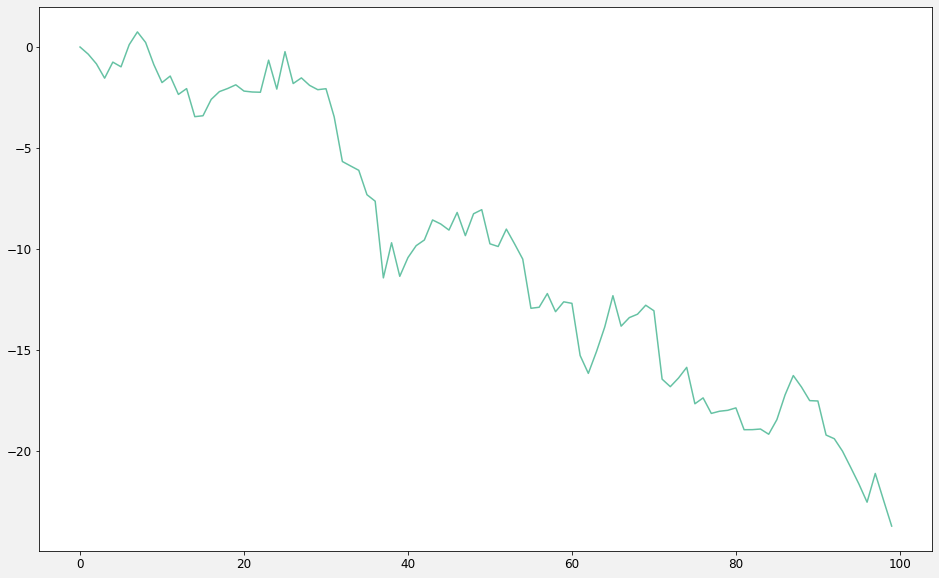

In [142]:
T=100
e = np.random.normal(0,1,T)
rho = 1 # the autoregressive coefficient
y = [0] #initial value 0
for i in range(T-1):
    y.append(rho*y[i] + e[i])
y = pd.Series(y)
y.plot()

Then we take a first difference using the *diff* command. 


<AxesSubplot:>

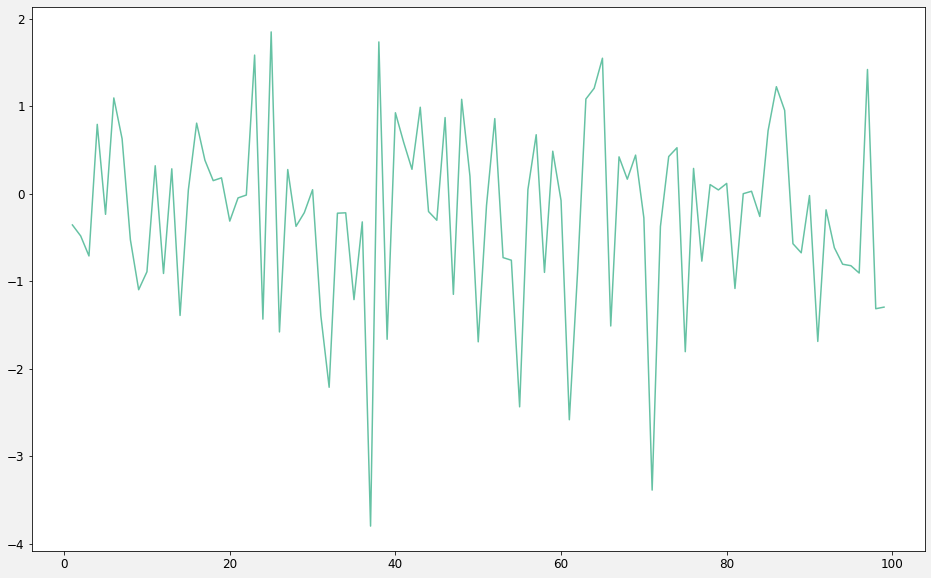

In [144]:
d_y = y.diff()
d_y.plot()

### Spurious regression

As an example of what can go wrong with non-stationary data, consider a time series model where you regress one series on another. 

As an example, consider the series, $x_t$ and $y_t$ which are both random walks:

$$x_t = x_{t-1} + \epsilon_t$$

$$y_t = y_{t-1} + u_t$$

Now, lets simulate both of these series a few times and each time run a regression of the one on the other. 

<AxesSubplot:>

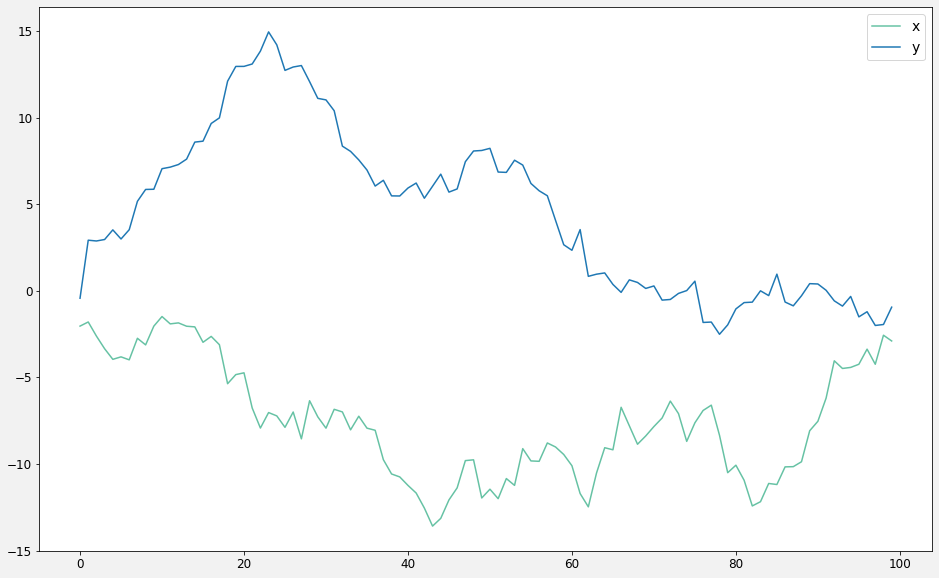

In [151]:
T=100
e = np.random.normal(0,1,T)
u = np.random.normal(0,1,T)

x = np.cumsum(e) #two independent random walks
y = np.cumsum(u)

spurDF = pd.DataFrame({"x":x, "y":y})
spurMod = smf.ols(formula="y~x-1", data=spurDF).fit()
spurDF.plot()

In [152]:
spurMod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.381
Model:                            OLS   Adj. R-squared (uncentered):              0.374
Method:                 Least Squares   F-statistic:                              60.82
Date:                Tue, 22 Feb 2022   Prob (F-statistic):                    6.47e-12
Time:                        15:56:32   Log-Likelihood:                         -305.50
No. Observations:                 100   AIC:                                      613.0
Df Residuals:                      99   BIC:                                      615.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x             -0.4900      0.063     -7.798      0.000      -0.615      -0.365
==============================================================================
Omnibus:                       13.788   Durbin-Watson:                   0.039
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                6.758
Skew:                           0.433   Prob(JB):                       0.0341
Kurtosis:                       2.067   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Make sure to run this simulation a handful of times, and note the estimated coefficients. What do you notice about the results? Keep in mind, that we simulated these two series as completely random and independent of each other.

You should notice that a "significant" coefficient is found on the x-variable much more often than would be suggested by pure chance. When we have non-stationary data, it is easy to over-interpret correlations in the data and make incorrect inference. In other words, when we have non-stationary data, the inference from our regression is invalid. 

We can take this one step further by doing a monte-carlo simulation and looking at the histogram of simulated b-coefficients. 

In [179]:
vcov = spurMod.cov_params()
vcov.iloc[0,0]

0.0032871913159591417

In [180]:
nsims=1000
T=100
bs =[]
ses =[]

for n in range(nsims):
    e = np.random.normal(0,1,T)
    u = np.random.normal(0,1,T)
    x = np.cumsum(e) #two independent random walks
    y = np.cumsum(u)
    spurDF = pd.DataFrame({"x":x, "y":y})
    spurMod = smf.ols(formula="y~x-1", data=spurDF).fit()
    bs.append(spurMod.params[0])
    vcov = spurMod.cov_params()
    ses.append(np.sqrt(vcov.iloc[0,0]))
    



In [183]:
ses = pd.Series(ses)
se_mean = ses.mean()

0.09628902917886842

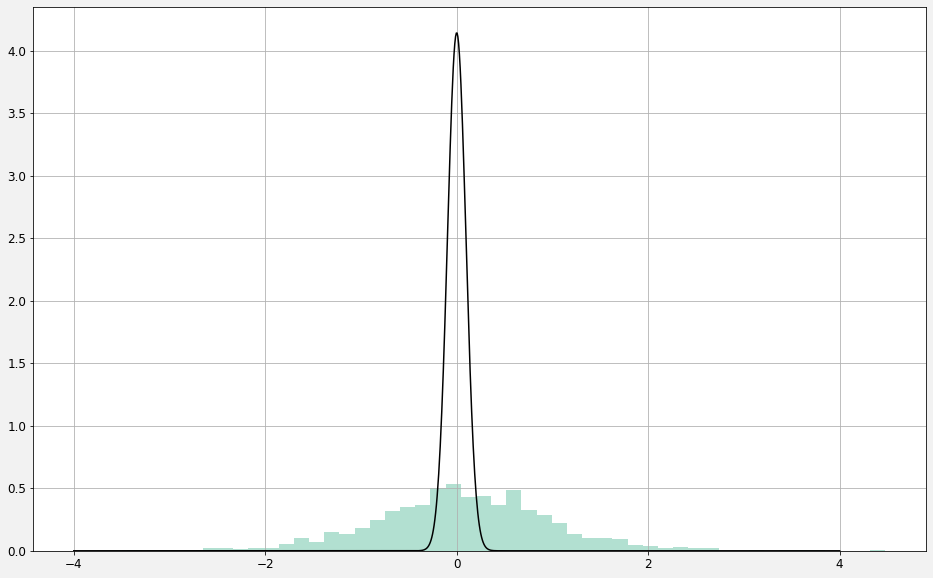

In [187]:
xs = np.linspace(-4,4,1000)

bs = pd.Series(bs)
fig, ax = plt.subplots()
bs.hist(bins=50, ax=ax, alpha=.5, density=True)
ax.plot(xs,spt.norm.pdf(xs,0,se_mean), color="black")

This chart shows the distribution of estimated coefficients (green), compared to what we would expect given the assumption of a normal distribution with a mean of 0 and using the mean of estimated standard errors as the standard deviation. As we can see, inference based on our standard assumptions when we have non-stationary data will not work at all. 

### Test for I(1)

How do we know if our series is non-stationary? As we have seen, we can often look at the series to get an idea. But it would be better to have a more formal way of testing for stationarity. 

If we have a series that we think is AR(1), then we could in principal just estimate the following regression: 

$y_t = \rho y_{t-1} + u_t$

We can simulate some data, setting $\rho=.8$ for example, and try: 

In [154]:
T=100
e = np.random.normal(0,1,T)
rho = .8 # the autoregressive coefficient
y = [0] #initial value 0
for i in range(T-1):
    y.append(rho*y[i] + e[i])
y = pd.Series(y)

Y = pd.DataFrame({"y":y, "y_l":y.shift()})
arMod2 = smf.ols(formula="y~y_l-1", data=Y).fit()
arMod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.567
Model:                            OLS   Adj. R-squared (uncentered):              0.562
Method:                 Least Squares   F-statistic:                              128.2
Date:                Tue, 22 Feb 2022   Prob (F-statistic):                    1.70e-19
Time:                        15:57:11   Log-Likelihood:                         -148.55
No. Observations:                  99   AIC:                                      299.1
Df Residuals:                      98   BIC:                                      301.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
y_l            0.7566      0.067     11.320      0.000       0.624       0.889
==============================================================================
Omnibus:                        1.305   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.521   Jarque-Bera (JB):                1.215
Skew:                          -0.267   Prob(JB):                        0.545
Kurtosis:                       2.902   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We should get back a coefficient on lag(y) that is pretty close to 0.8. But what happens if $\rho=1$?

In [158]:
T=100
e = np.random.normal(0,1,T)
rho = 1 # the autoregressive coefficient
y = [0] #initial value 0
for i in range(T-1):
    y.append(rho*y[i] + e[i])
y = pd.Series(y)

Y = pd.DataFrame({"y":y, "y_l":y.shift()})
arMod3 = smf.ols(formula="y~y_l-1", data=Y).fit()
arMod3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                              7372.
Date:                Wed, 23 Feb 2022   Prob (F-statistic):                    4.83e-94
Time:                        05:04:21   Log-Likelihood:                         -151.48
No. Observations:                  99   AIC:                                      305.0
Df Residuals:                      98   BIC:                                      307.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
y_l            1.0168      0.012     85.863      0.000       0.993       1.040
==============================================================================
Omnibus:                        0.605   Durbin-Watson:                   2.296
Prob(Omnibus):                  0.739   Jarque-Bera (JB):                0.717
Skew:                           0.062   Prob(JB):                        0.699
Kurtosis:                       2.602   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Often we might get a coefficient that is close to 1, but if you run the code a few times, you will see that we end up getting results that can vary by quite a lot. 

The point is to say, that running a regression like this to test for stationarity is problematic, because if the series IS non-stationary, then the regression is not valid. In other words, running such a regression is only a good test for stationarity if we already know the series is stationary!

Instead, we run a similar regression which, together with a distribution of the test result, we call the Dickey-fuller test: 

### Dickey-Fuller test:

For a AR(1) model: $y_t = \rho y_{t-1} + u_t$

Our Null hypothesis is:

$H_0: \rho=1$ is non-stationary

versus

$H_A: \rho<1$

Then we transform with a difference: 

$y_t - y_{t-1} = \rho y_{t-1} + e_t - y_{t-1}$

$\Delta y_{t-1} = (\rho - 1) y_{t-1} + u_t$

Thereby, if we define $\theta = \rho-1$, we get the following regresion model: 

$\delta y_t = \theta y_{t-1} + u_t$

Here the test is: 

$H_0: \theta=0$
$H_A: \theta<0$

If we run this test using a distribution of the test statistic called the Dickey-Fuller distribution, then that is the Dickey-Fuller test. 


### Augmented Dickey Fuller test

We often have to take into account more dynamics and serial correlation in a series. Then we use what we call the *Augmented Dickey-Fuller test*. 

A differenced series with AR(1) serial correlation (in $\Delta y_t$)  can be written:

$\Delta y_t = \theta y_{t-1} + \gamma \Delta y_{t-1} + e_t$

And generally with p lags: 

$\Delta y_t = \theta y_{t-1} + \gamma_1 \Delta y_{t-1} + ... + \gamma_p \Delta y_{t-p} + e_t$

and then test $\theta = 0$ with a Dickey-Fuller test as normal. 

Below we can see how we can quickly make use of the Dickey-Fuller test: 

### Testing for stationarity and transforming in practice.

In python and statsmodels we can easily run [ADF tests for stationarity](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html). Here we test the DK1 price series. First, we need to make sure there are no missing values in the series: 

In [194]:
from statsmodels.tsa.stattools import adfuller


DK1_price = DK_df2.DK1EurMW.loc[DK_df2.DK1EurMW.notna()]



In [199]:
dftest = adfuller(DK1_price, autolag="AIC") 
#the "autolag" parameter indicates that we let the algorithm find an optimal lag length

In [197]:
dftest

(-9.71021172028079,
 1.0163155629739258e-16,
 49,
 26251,
 {'1%': -3.430599131063867,
  '5%': -2.861650108618613,
  '10%': -2.5668286075580147},
 382593.9686878696)

Here we get a "tuple" of information. 

- The first number is the estimated ADF test statistikk. 
- The second number is the estimated p-value. 
- The third is the chosen number of lags
- The number of observations in the data
- Finally, a set of critical values associated with different significance levels

In our case, there is little ambiguity, we can with a high degree of certainty assume that this series is stationary. (remember, here the null-hypothesis is non-stationarity). 

It is not always that you always get a equally clear answer from an ADF test. It can sometimes be good to use another test of stationarity called the **KPSS test**. You can read more about implimenting this in python/statsmodels [here](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html). This has stationarity as the null hypothesis and non-stationarity as the alternative hypothesis, and sometimes this will give contradictory results compared to the ADF test. 

If in doubt, it might be best to assume non-stationarity, and transform the data.

### Serial Correlation

When a series is correlated over time, as long as it is stationary, we can still model it without bias. However, if we do not correctly account for the serial correlation, it can lead to standard errors that are no longer "efficient" -- that is to say that we can no longer count on our standard errors and p-values being correct. 

#### Testing for serial correlation

We run a simple regression of price on wind power now with no lags. 

From our simple regression we obtain our residuals. We plot our residuals against lagged residuals. This will give us an idea if there is serial correlation left in our data

In [213]:
sc_mod = smf.ols("DK1EurMW~wind_DK1", data=DK_df2).fit()

resids = sc_mod.resid
fitted = sc_mod.fittedvalues

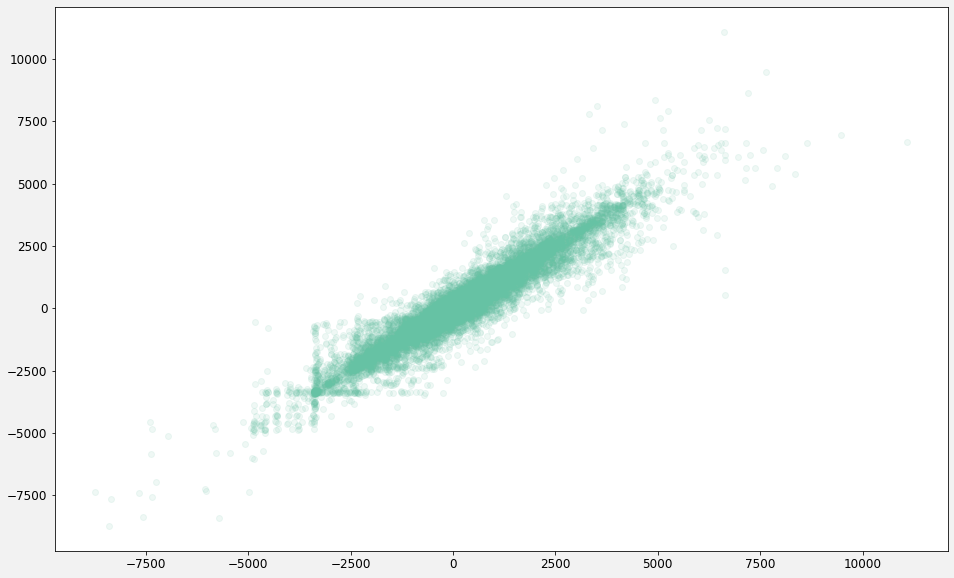

In [214]:
fig, ax = plt.subplots()
ax.scatter(resids, resids.shift(1), alpha=.1)

We see a clear relationship between residuals and lagged residuals indicating that there is a good deal of serial correlation in the residuals

To get a better view of the form of the serial correlation in our data, we can use **Autocorrelation Functions (ACF)** and **Partial Autocorrelation Functions**

In [217]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



In [220]:
resids

time
2016-01-01 01:00:00   -1750.698899
2016-01-01 02:00:00   -1773.861371
2016-01-01 03:00:00   -1803.079248
2016-01-01 04:00:00   -1802.766912
2016-01-01 05:00:00   -1778.690083
                          ...     
2018-12-31 19:00:00    1383.186500
2018-12-31 20:00:00    1243.105878
2018-12-31 21:00:00     975.314939
2018-12-31 22:00:00     510.958525
2018-12-31 23:00:00    -791.200154
Length: 26297, dtype: float64

/Users/johannesmauritzen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


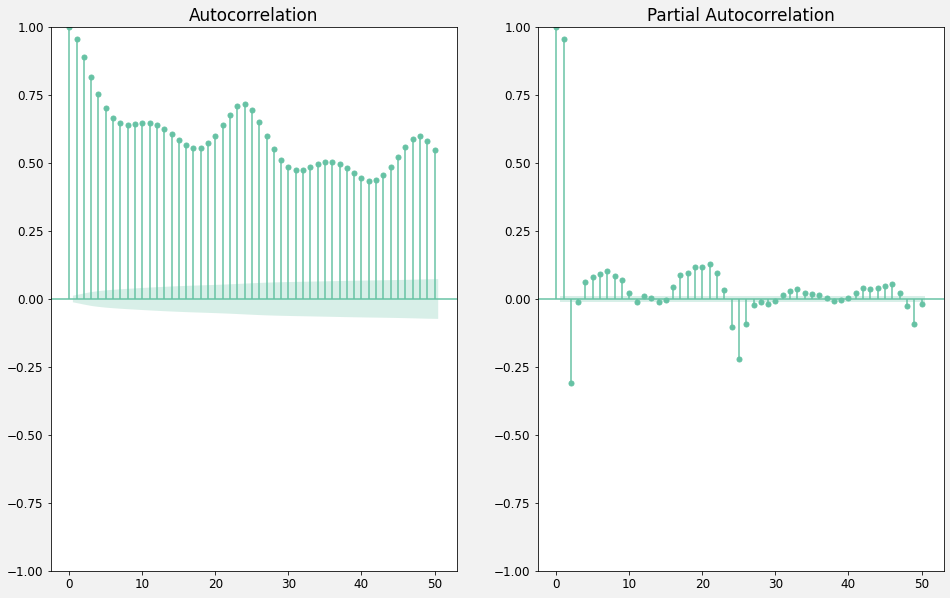

In [224]:
fig, ax = plt.subplots(1,2)
plot_acf(resids, lags=50, ax=ax[0])
plot_pacf(resids, lags=50, ax=ax[1])
plt.show()

* The ACF plot simply shows the pure correlations between the lags. Here we see strong, and long lived correlations. One way we can interpret the plot is to say that if we get a shock at time 0 of a magnitude of 1, how big will that shock be in the following periods.

* The PACF plto shows the correlations between lags, *controlling for the intermediate lags). This will be important in establishing the autoregressive nature of the data (next lab). 

A few solutions to dealing with serial correlation. 

- The first and perhaps best is to try to model the serial explicitly. We talk more about this in the following lab when we discuss 

- We could also take a first-difference. This will tend to eliminate a lot of serial correlation (in addition to non-stationarity). 

### Summary and preview

Now we have taken a quick tour of time series statistics. I hope you have gotten a sense of the most important issues: stationarity and serial correlation. If I had to summarize very quickly, I might say that most of time series can be divided into two questions:

1. Is the series stable over time (stationary). If not, then making estimates from the limited sample we have will not be particularly informative, since in the next (unseen) sample period, the time series could look completely different. This is the essence of stationarity. However, if we have a non-stationary series, we can try to transform it to a stationary series. Here differencing is often a simple and effective strategy. 

2. Once we have convinced ourselves that we are dealing with a stationary series, we then want to explore the dynamics (correlations) of the series and try to model that in the best possible way. 

It is point 2 that will be our jumping-off point for next lab. We take series and try to model the dynamics (correlations) of the series through what is called ARIMA modeling. We can then turn around this model to create a forecast. 

This forecast is perhaps not that useful in order to get a point estimate of a future value. Instead we can create scenarios and generate uncertainty that can inform us about risk in the future. 

We take this modeling one step further and introduce working with exogenous variables. The application we will be working with is estimating the effect of carbon trading permit prices on power prices, and then using such a model to create scenarios for different future levels of permit prices. 

# Assignment

In the *wt_data* data set we have information on net-exchange data for different countries and price areas in the Nordic exchange. That is, this indicates how much net import or export a country/area experiences over the course of an hour. Consider the net exchange series for DK1 and DK2: *DK1_nx* and *DK2_nx*. 

  a. Are these series stationary? Use and interpret with an appropriate test. Does the stationarity or non-stationarity of these series have some economic interpretation? If so, what does it say about these series? 
  
  b. Estimate what the effect of wind power is on net exchange in these two areas using OLS. Are there any lagged effects? Should you include any controlling variables? Such as prices, the other areas wind power, etc? Explain why or why not? Interpret the results. 
  
  c. Check the residuals for serial correlation (look at ACF and pACF figures). What effect does this have on our results or interpretation of results? If there are serial correlation, we should probably model the dynamics directly in our model, for example by including autoregressive (AR) terms in our regression. Will that effect how we interpret the exogenous coefficients (wind power)? [Chapter 9](https://otexts.com/fpp3/dynamic.html) parts 1-2 could be a useful reference in answering this question.  
  
  d. Throughout this lab, we have assumed that wind power is exogenous. That is, when we include it as an independent variable, we interpret the coefficients as causal. Is this justified? Why? What if we included price as a variable in the regresion in c. Should we interpret price as exogenous? 
 